In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import math
import numpy as np
import pandas as pd
import time
import string
import random
import sys
from logger import Logger
from abc import ABC
from datetime import timedelta
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
#from selection_strategy    import RandomSelectionStrategy
sys.path.insert(0,os.pardir)
from ga_inverse import readData
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
import matplotlib.animation as animation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from catboost import CatBoostRegressor
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import itertools
from scipy import stats


In [3]:
from abc import ABC

class SelectionStrategy(ABC):
    def select_next_instance():
        pass

class RandomSelectionStrategy(SelectionStrategy):
    def __init__(self):
        pass

    def select_next_instance(self, candidate_instances: pd.DataFrame):
        selected = np.random.choice(candidate_instances, size=1, replace=False)[0]
        return selected   

### Dataset Creation Functions

In [4]:
def plot_data_exists(data_path) -> bool:

    """ Check wheather plot data already exist and return the respective truth value.
        data_path1:     The path to look for the set of data."""

    if not os.path.exists(data_path):
        return False

    return True

# This function is responsible for preparing real-world datasets 

def data_preparation(sourceFile=None, research_data="zifs_diffusivity") -> list:

    Y = []
    X = []

    if research_data == "zifs_diffusivity":
        if sourceFile is not None:
            data_from_file = readData(sourceFile)
        else:
            data_from_file = readData()

        Y = ["logD"]
        X = ['diameter','mass','ascentricF', 'kdiameter','ionicRad',
            'MetalNum','MetalMass','σ_1', 'e_1',
            'linker_length1', 'linker_length2', 'linker_length3',
            'linker_mass1', 'linker_mass2', 'linker_mass3',
            'func1_length', 'func2_length', 'func3_length', 
            'func1_mass', 'func2_mass', 'func3_mass']
    
    elif research_data == "co2":
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={'CO2_working_capacity(mol/kg)':'working_capacity', 'mof_name':'type'})

        # One Hot Encode Data
        features = ["Nodular_BB1", "Nodular_BB2", "Connecting_BB1", "Connecting_BB2"]
        data_from_file = pd.get_dummies(data_from_file, columns=features,dtype=int)

        Y = ["working_capacity"]
        X = [feature_label for base_label in features for feature_label in list(data_from_file.columns) if base_label in feature_label]

    elif research_data == "co2/n2":
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={'CO2/N2_selectivity':'selectivity', 'mof_name':'type'})

        # One Hot Encode Data
        features = ["Nodular_BB1", "Nodular_BB2", "Connecting_BB1", "Connecting_BB2"]
        data_from_file = pd.get_dummies(data_from_file, columns=features,dtype=int)

        Y = ["selectivity"]
        X = [feature_label for base_label in features for feature_label in list(data_from_file.columns) if base_label in feature_label]    

    elif research_data == "o2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["SelfdiffusionofO2cm2s"] = np.log(data_from_file["SelfdiffusionofO2cm2s"])
        data_from_file = data_from_file.rename(columns={'SelfdiffusionofO2cm2s':'logSelfD','MOFRefcodes': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD',	'PLD',	'LFPD',	'Volume',	'ASA_m2_g',	
             'ASA_m2_cm3',	'NASA_m2_g', 'NASA_m2_cm3',	
             'AV_VF',	'AV_cm3_g',	'NAV_cm3_g', ' H', 'C',	'N', 'metal type', 
             ' total degree of unsaturation', 'metalic percentage',	' oxygetn-to-metal ratio',	
             'electronegtive-to-total ratio', ' weighted electronegativity per atom', 
             ' nitrogen to oxygen ']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'

    elif research_data == "n2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["SelfdiffusionofN2cm2s"] = np.log(data_from_file["SelfdiffusionofN2cm2s"])
        data_from_file = data_from_file.rename(columns={'SelfdiffusionofN2cm2s':'logSelfD','MOFRefcodes': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD',	'PLD',	'LFPD',	'Volume',	'ASA_m2_g',	
             'ASA_m2_cm3',	'NASA_m2_g', 'NASA_m2_cm3',	
             'AV_VF',	'AV_cm3_g',	'NAV_cm3_g', ' H', 'C',	'N', 'metal type', 
             ' total degree of unsaturation', 'metalic percentage',	' oxygetn-to-metal ratio',	
             'electronegtive-to-total ratio', ' weighted electronegativity per atom', 
             ' nitrogen to oxygen ']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'         

    elif research_data == "ch4":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_CH4 (cm2/s)"] = np.log(data_from_file["D_CH4 (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_CH4 (cm2/s)':'logSelfD','MOF name': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)',
        '%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','O-to-M','MP','TDU','DU']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'

    elif research_data == "h2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_H2 (cm2/s)"] = np.log(data_from_file["D_H2 (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_H2 (cm2/s)':'logSelfD','MOF': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)',
        '%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','O-to-M','MP','TDU','DU']

    elif research_data == "he":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_He (cm2/s)"] = np.log(data_from_file["D_He (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_He (cm2/s)':'logSelfD','MOF': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)','%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','TDU','DU','MP','O-to-M']    

    else:
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={' absolute methane uptake high P [v STP/v]':'methane_uptake', ' name':'type'})        

        Y = ['methane_uptake']
        X = ['dimensions', ' supercell volume [A^3]', ' density [kg/m^3]',
             ' surface area [m^2/g]', ' num carbon', ' num hydrogen',
             ' num nitrogen', ' num oxygen', ' num sulfur', ' num silicon',
             ' vertices', ' edges', ' genus', ' largest included sphere diameter [A]',
             ' largest free sphere diameter [A]', ' largest included sphere along free sphere path diameter [A]']

    return data_from_file, X, Y

In [6]:
# Dataset Creation Forrester

def Forrester(heterogeneity = True):

    np.random.seed(10)
    # 1-d dataset Forrester Function 
    #x = np.linspace(0, 1, 1000)

    if(heterogeneity):
        # Generate a large number of x values in the range [0.6, 0.9) and ensure uniqueness
        x_60 = np.random.choice(np.linspace(0.6, 0.9, 10000), size=600, replace=False)

        # Generate a large number of x values in the range [0, 0.6) and ensure uniqueness
        x_20_1 = np.random.choice(np.linspace(0, 0.6, 10000), size=200, replace=False)

        # Generate a large number of x values in the range [0.9, 1] and ensure uniqueness
        x_20_2 = np.random.choice(np.linspace(0.9, 1, 10000), size=200, replace=False)

        # Combine the x values
        x = np.concatenate((x_60, x_20_1, x_20_2))

    else:
        # 1000 evenly spaced samples
        x = np.linspace(0, 1, 1000)    

    
    # Sort x values 
    x = np.sort(x)

    # Calculate the corresponding y values using the given formula
    y = (6 * x - 2) ** 2 * np.sin(12 * x - 4)

    # Create unique names for each sample
    types = [f"Sample_{i+1}" for i in range(1000)]

    # Create a DataFrame with columns x, y, and type
    np_data = pd.DataFrame({'x': x, 'y': y, 'type': types})

    featureNames = ['x']
    targetNames = ['y']
    
    return np_data, featureNames, targetNames


In [14]:
# Dataset Creation Jump Forrester

def JumpForrester(heterogeneity = True):

    np.random.seed(10)

    if(heterogeneity):

        x1 = np.random.choice(np.linspace(0, 0.5, 10000), size=300, replace=False)
        x2 = np.random.choice(np.linspace(0.5, 1, 10000), size=700, replace=False)
    
    else:  

        x1 = np.linspace(0, 0.5, 500)
        x2 = np.linspace(0.5, 1, 500)

    
    x = np.concatenate((x1,x2))


    y1 = (6 * x1 - 2) ** 2 * np.sin(12 * x1 - 4)
    y2 = (6 * x2 - 2) ** 2 * np.sin(12 * x2 - 4) + 10
    y = np.concatenate((y1,y2))

    # Create unique names for each sample
    types = [f"Sample_{i+1}" for i in range(1000)]

    # Create a DataFrame with columns x, y, and type
    np_data = pd.DataFrame({'x': x, 'y': y, 'type': types})

    featureNames = ['x']
    targetNames = ['y']

    return np_data, featureNames, targetNames


In [16]:
# Define a function to calculate y
def calculate_y_ALOS(x1, x2):
    return np.sin(21*(x1-0.9)**4) * np.cos(2*(x1-0.9)) + (x1-0.7)/2 + 2*(x2**2) * np.sin(x1)

# Dataset Creation ALOS D=2
def ALOS():
    np.random.seed(10)
    
    # Define x1, x2 ranges
    x1 = np.linspace(0, 1, 100)
    x2 = np.linspace(0, 1, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs = np.array(list(itertools.product(x1, x2)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
    selected_pairs = all_pairs[selected_indices]

    # Calculate y for each pair
    y = np.array([calculate_y_ALOS(pair[0], pair[1]) for pair in selected_pairs])
    
    # Create unique id for each sample
    types = [f"Sample_{i+1}" for i in range(2000)]

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
    np_data['y'] = y
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']
    
    return np_data, featureNames, targetNames

In [17]:
# Dataset Creation ALOS D=2 heterogeneous

def ALOS_heterogeneous():
    
    np.random.seed(10)
    
    x1_1 = np.linspace(0, 0.2, 20)
    x1_2 = np.linspace(0.2, 0.4, 20)
    x1_3 = np.linspace(0.4, 1, 60)
    x2 = np.linspace(0, 1, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs1 = np.array(list(itertools.product(x1_1, x2)))
    all_pairs2 = np.array(list(itertools.product(x1_2, x2)))
    all_pairs3 = np.array(list(itertools.product(x1_3, x2)))


    # Randomly select 2000 unique pairs
    selected_indices1 = np.random.choice(len(all_pairs1), size=300, replace=False)
    selected_pairs1 = all_pairs1[selected_indices1]

    selected_indices2 = np.random.choice(len(all_pairs2), size=700, replace=False)
    selected_pairs2 = all_pairs2[selected_indices2]

    selected_indices3 = np.random.choice(len(all_pairs3), size=1000, replace=False)
    selected_pairs3 = all_pairs3[selected_indices3]

    selected_pairs = np.concatenate((selected_pairs1,selected_pairs2,selected_pairs3))

    # Calculate y for each pair
    y = np.array([calculate_y_ALOS(pair[0], pair[1]) for pair in selected_pairs])

    types = [f"Sample_{i+1}" for i in range(2000)]

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
    np_data['y'] = y
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']

    return np_data, featureNames, targetNames


In [18]:
# Define the 2D Gaussian function
def gaussian_2d(x1, x2, sigma=1):
    return np.exp(-(x1**2 + x2**2) / (2 * sigma**2))

# Dataset Gaussian

def Gaussian():
    np.random.seed(10)
    # Generate linspace for x1 and x2
    x1 = np.linspace(-3, 3, 100)
    x2 = np.linspace(-3, 3, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs = np.array(list(itertools.product(x1, x2)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
    selected_pairs = all_pairs[selected_indices]

    # Calculate y for each pair
    y = np.array([gaussian_2d(pair[0], pair[1]) for pair in selected_pairs])

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
    np_data['y'] = y

    types = [f"Sample_{i+1}" for i in range(2000)]
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']
    
    return np_data, featureNames, targetNames

In [19]:
# Heterogeneous Gaussian

def Gaussian_heterogeneous():
    np.random.seed(10)

    # Generate linspace for x1 and x2
    x1_1 = np.linspace(-0.5, 0.5, 100)
    x2_1 = np.linspace(-0.5, 0.5, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
    selected_pairs1 = all_pairs1[selected_indices]

    # Generate linspace for x1 and x2
    x1_2 = np.linspace(-3, 3, 100)
    x2_2 = np.linspace(-3, 3, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

    # Find all pairs that do not belong in the central area
    outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= -0.5) & (all_pairs[:, 0] <= 0.5) & 
                                    (all_pairs[:, 1] >= -0.5) & (all_pairs[:, 1] <= 0.5))]


    selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
    selected_outside_pairs = outside_range_pairs[selected_outside_indices]


    combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])

    
    # Calculate y for each pair
    y = np.array([gaussian_2d(pair[0], pair[1]) for pair in combined_pairs])

    # Combine x1, x2, and y into a DataFrame
    np_data2 = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
    np_data2['y'] = y

    # Assign sample types
    types = [f"Sample_{i+1}" for i in range(2000)]
    np_data2['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']

    return np_data, featureNames, targetNames


In [5]:
# Define the 2D Gaussian function with noise
def gaussian_2d_noise(x1, x2,noise,sigma=1):
    return np.exp(-(x1**2 + x2**2) / (2 * sigma**2)) + np.random.uniform(0, noise)

def Gaussian_noise():
    # Heterogeneous Gaussian + noise
    np.random.seed(10)

    # Generate linspace for x1 and x2
    x1_1 = np.linspace(-0.5, 0.5, 100)
    x2_1 = np.linspace(-0.5, 0.5, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
    selected_pairs1 = all_pairs1[selected_indices]

    y1 = np.array([gaussian_2d(pair[0], pair[1],0.5) for pair in selected_pairs1])

    # Generate linspace for x1 and x2
    x1_2 = np.linspace(-3, 3, 100)
    x2_2 = np.linspace(-3, 3, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

    # Find all pairs that do not belong in the central area
    outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= -0.5) & (all_pairs[:, 0] <= 0.5) & 
                                    (all_pairs[:, 1] >= -0.5) & (all_pairs[:, 1] <= 0.5))]


    selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
    selected_outside_pairs = outside_range_pairs[selected_outside_indices]

    y2 = np.array([gaussian_2d_noise(pair[0], pair[1], 0.2) for pair in selected_outside_pairs])

    combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])


    # Calculate y for each pair
    y = np.concatenate((y1,y2))

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
    np_data['y'] = y

    # Assign sample types
    types = [f"Sample_{i+1}" for i in range(2000)]
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']

    return np_data, featureNames, targetNames

In [20]:
# Define a function to calculate y
def calculate_y_exp(x1, x2):
    return 1 - np.exp(-0.6 * ((x1 - 0.5)**2 + (x2 - 0.5)**2))

def Exponential():
    np.random.seed(10)
    x1 = np.linspace(0, 1, 100)
    x2 = np.linspace(0, 1, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs = np.array(list(itertools.product(x1, x2)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
    selected_pairs = all_pairs[selected_indices]


    # Calculate y for each pair
    y = np.array([calculate_y_exp(pair[0], pair[1]) for pair in selected_pairs])

    types = [f"Sample_{i+1}" for i in range(2000)]

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
    np_data['y'] = y
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']

    return np_data, featureNames, targetNames

In [22]:
def Exponential_heterogeneous():
    
    np.random.seed(10)

    # Generate linspace for x1 and x2
    x1_1 = np.linspace(0.2, 0.8, 100)
    x2_1 = np.linspace(0.2, 0.8, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
    selected_pairs1 = all_pairs1[selected_indices]

    # Generate linspace for x1 and x2
    x1_2 = np.linspace(0, 1, 100)
    x2_2 = np.linspace(0, 1, 100)

    all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

    outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= 0.2) & (all_pairs[:, 0] <= 0.8) & 
                                    (all_pairs[:, 1] >= 0.2) & (all_pairs[:, 1] <= 0.8))]


    selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
    selected_outside_pairs = outside_range_pairs[selected_outside_indices]


    combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])


    # Calculate y for each pair
    y = np.array([calculate_y_exp(pair[0], pair[1]) for pair in combined_pairs])

    # Combine x1, x2, and y into a DataFrame
    np_data2 = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
    np_data2['y'] = y

    # Assign sample types
    types = [f"Sample_{i+1}" for i in range(2000)]
    np_data2['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']
    
    return np_data, featureNames, targetNames

### Method Definitions

In [5]:
### GP uncertainty
def Gp_uncertainty(X_train,y_train,X_unlabeled,featureNames):
    
    # Extract the features for the unlabeled data from the specified featureNames
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    # Define the Gaussian Process surrogate model with a RationalQuadratic kernel
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))

    # Train the GP model on the training data (X_train, y_train).
    gp_model.fit(X_train,y_train.ravel())

    # Predict the output and uncertainties (standard deviations) for the unlabeled data.
    y_pred, y_std = gp_model.predict(x_unlabeled,return_std=True)

    uncertainties = y_std #.argsort()[-1:]
    
    return uncertainties

In [6]:
def qbc(model,X_train,y_train,X_unlabeled,featureNames,targetNames):
    
    # Extract the features for the unlabeled data from the specified featureNames
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    # Define and train a Gaussian Process as the first predictor 
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))  
    gp_model.fit(X_train,y_train.ravel())
    y_pred1, y_std = gp_model.predict(x_unlabeled,return_std=True)

    # Use the already trained XGBoost regressor as the second predictor
    y_pred2 = model.predict(x_unlabeled)

    # Define and train a Random Forest Regressor as the third predictor 
    regr = RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X_train,y_train.ravel())
    y_pred3 = regr.predict(x_unlabeled)

    # Measure the pairwise disagreement of the committee's models as their 1-d euclidean distance 
    d1 = np.abs((y_pred1-y_pred2))
    d2 = np.abs((y_pred1-y_pred3))
    d3 = np.abs((y_pred2-y_pred3)) 
    
    # Uncertainty is the mean of the three distances 
    res = (d1 + d2 + d3)/3

    # stacked_ypreds = np.vstack((y_pred1, y_pred2, y_pred3))

    # # Calculate the standard deviation along the first axis (row-wise)
    # res = np.std(stacked_ypreds, axis=0)
     
    return res 


In [6]:
def Gsx(model,X_train,y_train,X_unlabeled,featureNames):

    # Convert the specified features from the unlabeled data to a numpy array
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    # Calculate the Euclidean distances between each unlabeled sample and the training data
    distances = cdist(x_unlabeled, X_train, metric='euclidean')
    
    # Find the minimum distance for each unlabeled sample
    min_distances = np.min(distances, axis=1)

    # Get the index of the unlabeled sample that has the largest minimum distance
    result_index = np.argmax(min_distances)
    
    return  result_index, min_distances

In [7]:
def Gsy(model,X_train,y_train,X_unlabeled,featureNames):

    # Convert the specified features from the unlabeled data to a numpy array
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    # Predict the labels for the unlabeled data using the provided model
    y_pred = model.predict(x_unlabeled)
    
    # Ensure that y_train is a 1D array
    y_train = y_train.ravel()

    min_distances = []

    # For each predicted label in y_pred
    for pred in y_pred:
        
        # Compute the absolute difference between each training label and the predicted label
        distances = np.abs((y_train - pred))

        # Find the minimum distance for the current prediction
        min_distances.append(np.min(distances))
    
    
    min_distances = np.array(min_distances)
    
    # Find the index of the unlabeled sample that has the largest minimum distance
    result_index = np.argmax(min_distances)
    
    return  result_index, min_distances 

In [8]:
def iGS(model,x_train,y_train,x_unlabeled,featureNames):
    
    # Run GSx method to obtain the uncertainties for x-axis
    res_x,dist_x = Gsx(model,x_train,y_train,x_unlabeled,featureNames)

    # Run GSy method to obtain the uncertainties for y-axis
    res_y,dist_y = Gsy(model,x_train,y_train,x_unlabeled,featureNames)

    # For each unlabeled sample find the product of GSx and GSy uncertainty
    dist = dist_x * dist_y

    # Find the index of the unlabeled sample that has the largest distance
    result_index = np.argmax(dist)
    
    return result_index, dist

In [9]:
def density_unc(model,x_train,y_train,X_unlabeled,featureNames):
    
    # Convert the specified features from the unlabeled data to a numpy array
    x_unlabeled = X_unlabeled[featureNames].to_numpy()

    # For each unlabeled sample find the n_neighbors closest unlabeled neighbours and extract their distances from the sample
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(x_unlabeled)
    distances, indices = nbrs.kneighbors(x_unlabeled)

    # Calculate density factor
    density = 1 / distances.mean(axis=1)

    # Run the iGS method to produce uncertainties 
    index, uncertainty = iGS(model,x_train,y_train,X_unlabeled,featureNames) #Gp_uncertainty(x_train,y_train,X_unlabeled,featureNames)
    
    # Find the index of the unlabeled sample that has the largest weighted uncertainty
    result_index = np.argmax(uncertainty * density)

    return result_index
    

In [22]:
class OptimizationFactory(ABC):
    def optimizeModel():
        pass

class ActiveLearning(OptimizationFactory):

    
    def optimizeModel(self, model : any, data : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, method : string ,seedno : int, exp_num : int) -> pd.DataFrame:
        
        """
        - model:                The predictor model we want to train
        - data:                 The dataset
        - X_featureNames:       A list containing the names of feature columns of the dataset that will be used in training
        - Y_featureNames:       A list containing the names of target columns of the dataset that will be used in training
        - designspace_thres:    The number of queries at the oracle
        - method:               The Active Learning method for calculating uncertainty 
        - seedno:               The seed number
        - exp_num:              The experiment number that specifies the file of the initial samples

        """
        # Check if the 'method' parameter has valid value 
        if(method!='density' and method!='iGS'):
            print("Invalid Method")
            return
        
        np.random.seed(seedno)
        
        # Find the names of unique samples (in some datasets there are multiple records with same type and we want to group them)
        uniqueNames = data.type.unique()

        # Define number of folds
        fold_num = 10
        
        # Define the maximum number of queries 
        select_data_points_num = designspace_thres

        # Kfold creation with random shuffling
        data_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=seedno)
        
        # Define result dictionairy, the list that contains all the queried names and the list that contains their target properties
        maePerTrainSize = {}
        names = []
        target = []
        inner_round = 0
        
        # Start of the kfold rounds
        for train_data_indicies, left_out_data_indicies in data_kfold.split(uniqueNames):
           
            # Set the seed at each round for reproducibility 
            np.random.seed(seedno)
            
            # Identify the train data and the test data partitions of the kfold split
            trainDataNames = np.delete(uniqueNames, left_out_data_indicies)
            testDataNames   = uniqueNames[left_out_data_indicies]

            # These dataframes contain the unlabeled set (trainData) of the round and the test set used only for model evaluation (testData)
            trainData = data[~data['type'].isin(testDataNames)]
            testData  = data[data['type'].isin(testDataNames)]

            # This dataframe contains the current train set 
            currentData   = pd.DataFrame()
            
            inner_round += 1
            random_flag  = False # Used when the active counter loop is active
            active_counter = 0 # Used when the active counter loop is active
            
            # Load specific, randomly chosen initial indexes for selecting samples for reproducibility across all AL methods
            init_indexes = np.load(f'./Init_Index/start_{exp_num}.npy')
            
            # Select five random samples (simulated through the random indexes from init_indexes)
            for random_index in init_indexes:
                
                # Find sample name that corresponds to specified index
                randomSampleName = trainData.iloc[random_index]["type"]
                # Find sample that corresponds to selected name
                selectedSample  = trainData[(trainData['type'] == randomSampleName)]

                # Add selected name and target property         
                names.append(randomSampleName)
                target.append(selectedSample[Y_featureNames])
                
                # Remove selected sample from unlabeled set
                trainData     = trainData[(trainData['type']) != randomSampleName]
                trainDataNames = np.delete(trainDataNames, np.where(trainDataNames == randomSampleName))

                # Add selected sample to train set
                currentData = pd.concat([currentData, selectedSample], axis=0, ignore_index=True)
            
            # Convert train set to numpy array with specified features and train the predictor
            x_trainAL = currentData[X_featureNames].to_numpy()
            y_trainAL = currentData[Y_featureNames].to_numpy()  

            model.fit(x_trainAL, y_trainAL.ravel())  
            
            # Start of the Active Learning loop where select_data_points_num-5 queries will be made 
            for sizeOfTrainData in range(select_data_points_num-5):
                
                # If random_flag is enabled select randomly one sample to query
                if random_flag:
                    
                    # Randomly Select sample name and identify the sample
                    randomSelection = RandomSelectionStrategy()
                    randomSampleName = randomSelection.select_next_instance(trainDataNames)
                    selectedSample  = trainData[(trainData['type'] == randomSampleName)]
                    
                    # Add selected name and target property
                    names.append(randomSampleName)
                    target.append(selectedSample[Y_featureNames])

                    # Remove the selected sample from the unlabeled set
                    trainData     = trainData[(trainData['type']) != randomSampleName]
                    trainDataNames = np.delete(trainDataNames, np.where(trainDataNames == randomSampleName))

                    # Add selected sample to the train set
                    currentData = pd.concat([currentData, selectedSample], axis=0, ignore_index=True)
                    
                    # Disable random_flag
                    random_flag  = False
                 

                else:
                    
                    # Use Active Learning method to measure uncertainty and select sample index
                    if(method=='density'):

                        select_index = density_unc(model,x_trainAL, y_trainAL,trainData,X_featureNames)
                    else:

                        select_index, dist= iGS(model,x_trainAL, y_trainAL,trainData,X_featureNames)
                    
                    # Find sample name based on index and identify sample
                    selected_name = trainData.iloc[select_index]["type"]
                    selectedSample = trainData[(trainData['type'] == selected_name)]
                    
                    # Add selected name and target property
                    names.append(selected_name)
                    target.append(selectedSample[Y_featureNames])
                    
                    # Remove the selected sample from the unlabeled set
                    trainData = trainData[(trainData['type']) != selected_name]
                    trainDataNames = np.delete(trainDataNames, np.where(trainDataNames == selected_name))
                    
                    # Add selected sample to the train set
                    currentData = pd.concat([currentData, selectedSample], axis=0, ignore_index=True)

                        
                    ### Uncomment if we want to add a random sample after active_counter iterations     
                    # active_counter += 1
                    # if(active_counter==10):
                    #     random_flag  = True
                    #     active_counter = 0

                
                # Convert train set to numpy array with specified features
                x_trainAL = currentData[X_featureNames].to_numpy()
                y_trainAL = currentData[Y_featureNames].to_numpy()

                # Calculate train set's length
                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                
                # Check if the train set contains more than the initial samples
                if(trainLength>=5):
                    
                    # Train XGBoost with the updated dataset 
                    model.fit(x_trainAL, y_trainAL.ravel())
                    
                    # Convert evaluation dataframe to numpy arrays with specified features 
                    x_test  = testData[X_featureNames].to_numpy()
                    y_test  = testData[Y_featureNames].to_numpy()
                    
                    # Prediction on outer leave one out test data
                    y_pred = model.predict(x_test)
                    
                    # Prediction of model over the data in the train set
                    y_pred_train = model.predict(x_trainAL)

                    # Calculate MAE for both evaluations
                    mae_train = metrics.mean_absolute_error(y_trainAL,y_pred_train)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    
                    print("Round",inner_round,"train size",sizeOfTrainData+1,"mae is",mae,"train_mae is",mae_train)
  
    
                    if (sizeOfTrainData + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainData + 1)] = []

                          
                    # Append test set's MAE to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainData + 1)].append(mae)
            
            
        
            
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df,names,target



In [24]:
class RandomSampling(OptimizationFactory):

    
    def optimizeModel(self, model : any, data : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, seedno : int, exp_num : int) -> pd.DataFrame:
        
        """
        - model:                The predictor model we want to train
        - data:                 The dataset
        - X_featureNames:       A list containing the names of feature columns of the dataset that will be used in training
        - Y_featureNames:       A list containing the names of target columns of the dataset that will be used in training
        - designspace_thres:    The number of queries at the oracle
        - seedno:               The seed number
        - exp_num:              The experiment number that specifies the file of the initial samples

        """
        np.random.seed(seedno)
        
        # Find the names of unique samples (in some datasets there are multiple records with same type and we want to group them)
        uniqueData = data.type.unique()
        
        # Define number of folds
        fold_num = 10
        
        # Define the maximum number of queries
        select_data_points_num = designspace_thres

        # Kfold creation with random shuffling
        data_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=seedno)
        
        # Define result dictionairy, the list that contains all the queried names and the list that contains their target properties
        maePerTrainSize = {}
        names = []
        target = []
        inner_round = 0 
        
        # Start of the kfold rounds
        for train_data_indicies, left_out_data_indicies in data_kfold.split(uniqueData):
            
            # Set the seed at each round for reproducibility 
            np.random.seed(seedno)
            
            inner_round += 1
            
            # Identify the train data and the test data partitions of the kfold split
            trainDataNames = np.delete(uniqueData, left_out_data_indicies)
            testDataNames   = uniqueData[left_out_data_indicies]

            # These dataframes contain the unlabeled set (trainData) of the round and the test set used only for model evaluation (testData)
            trainData = data[~data['type'].isin(testDataNames)]
            testData  = data[data['type'].isin(testDataNames)]
            
            # This dataframe contains the current train set
            currentData   = pd.DataFrame()

            # Load specific, randomly chosen initial indexes for selecting samples for reproducibility across all AL methods    
            init_indexes = np.load(f'./Init_Index/start_{exp_num}.npy')

            # Select five random samples (simulated through the random indexes from init_indexes)
            for random_index in init_indexes:

                # Find sample name that corresponds to specified index
                randomSampleName = trainData.iloc[random_index]["type"]
                # Find sample that corresponds to selected name
                selectedSample  = trainData[(trainData['type'] == randomSampleName)]

                # Add selected name and target property        
                names.append(randomSampleName)
                target.append(selectedSample[Y_featureNames])
                
                # Remove selected sample from unlabeled set
                trainData     = trainData[(trainData['type']) != randomSampleName]
                trainDataNames = np.delete(trainDataNames, np.where(trainDataNames == randomSampleName))

                # Add selected sample to train set
                currentData = pd.concat([currentData, selectedSample], axis=0, ignore_index=True)
            
            
            # Start of the Random Selection loop where select_data_points_num-5 queries will be made
            for sizeOfTrainData in range(select_data_points_num-5):

                
                # Randomly Select sample name and identify the sample
                randomSelection = RandomSelectionStrategy()
                randomSampleName = randomSelection.select_next_instance(trainDataNames)
                selectedSample  = trainData[(trainData['type'] == randomSampleName)]
                
                # Add selected name and target property
                names.append(randomSampleName)
                target.append(selectedSample[Y_featureNames])
                
                # Remove selected sample from unlabeled set
                trainData     = trainData[(trainData['type']) != randomSampleName]
                trainDataNames = np.delete(trainDataNames, np.where(trainDataNames == randomSampleName))

                # Add selected sample to train set
                currentData = pd.concat([currentData, selectedSample], axis=0, ignore_index=True)
                
                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                
                # Check if the train set contains more than the initial samples
                if(trainLength>=5):

                    # Train XGBoost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Convert evaluation dataframe to numpy arrays with specified features
                    x_test  = testData[X_featureNames].to_numpy()
                    y_test  = testData[Y_featureNames].to_numpy()

                    # Prediction on outer leave one out test data
                    y_pred = model.predict(x_test)

                    # Prediction on data that exist in the train set
                    y_pred_train = model.predict(x_trainAll)
                    
                    # Calculate MAE for both evaluations
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    mae_train = metrics.mean_absolute_error(y_trainAll, y_pred_train)
                    
                    print("Round",inner_round,"train size",sizeOfTrainData + 1,"mae is",mae, "train_mae is",mae_train)
  

                    if (sizeOfTrainData + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainData + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainData + 1)].append(mae)
            
            
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df,names,target

### Experimental Process

In [ ]:
np.random.seed(10)
# Initial Query Selection Indexes
for i in range(10):

    #start_indexes = np.random.choice(np.arange(0,100),size=5,replace=False)
    print(np.load(f'./Init_Index/start_{i}.npy'))

In [26]:
#np_data, featureNames, targetNames = data_preparation("../train_data/train_zifs_diffusivity/TrainData.xlsx")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Methane.csv",research_data = "ch4")
#np_data, featureNames, targetNames = data_preparation("../train_data/properties.csv",research_data = "methane")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFdata.csv",research_data = "o2")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Hydrogen.csv",research_data = "h2")
np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Helium.csv",research_data = "he")
#np_data, featureNames, targetNames = data_preparation("../train_data/alpha_ads_data_and_CO2_WC_data.csv",research_data = "co2/n2")

# Instantiate the XGB regressor model
XGBR = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                        random_state=6410 ) #,device = "cuda"

In [ ]:
warnings.filterwarnings('ignore')

# Example 10-experiment run of ActiveLearning method 
for i in range(10):
    optimizer = ActiveLearning()
    result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, method = "iGS" ,seedno=(i+1)*10 , exp_num=i)
    result.to_csv(f"./ALresults/Synthetic/Exponential/Exponential_imb/Al_exp_150_oracle_only_iGS_{i}.csv", index=False)
       

In [ ]:
warnings.filterwarnings('ignore')

# Example 10-experiment run of RandomSampling method
for i in range(10):
    optimizer = RandomSampling()
    result,name2,y2 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, seedno=(i+1)*10 , exp_num=i)
    result.to_csv(f"./ALresults/Synthetic/Exponential/Exponential_imb/Rd_exp_150_full_{i}.csv", index=False)
    

### Example of PCA plots

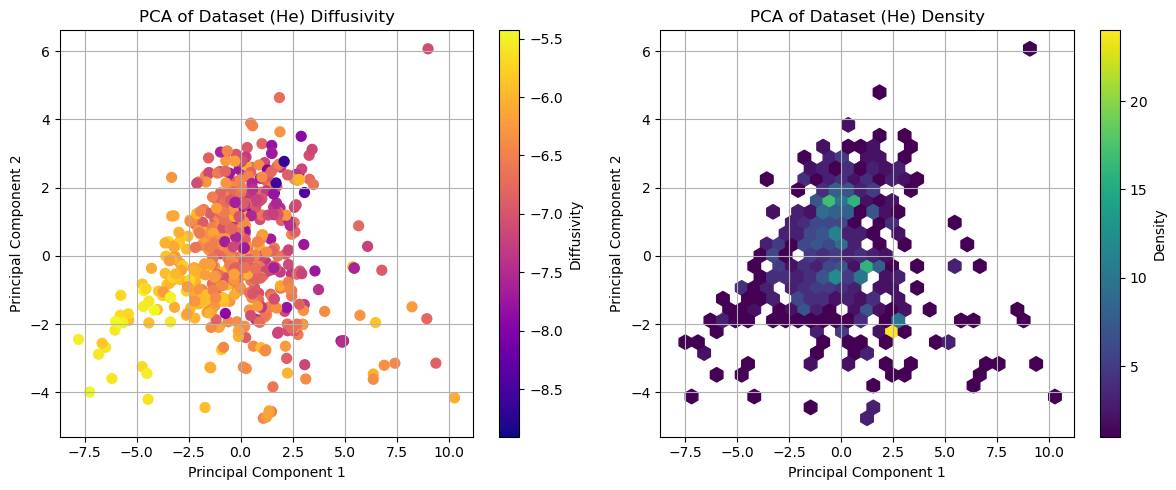

In [74]:
# Assuming np_data, featureNames, and targetNames are already defined
x = np_data[featureNames].to_numpy()
y = np_data[targetNames].to_numpy()

# Normalize the data
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_normalized)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Scatter plot
scatter = ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='plasma', s=50)
ax[0].set_title('PCA of Dataset (He) Diffusivity')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].grid(True)
cbar1 = fig.colorbar(scatter, ax=ax[0])
cbar1.set_label('Diffusivity')

# Second subplot: Hexbin plot
hb = ax[1].hexbin(X_pca[:, 0], X_pca[:, 1], gridsize=30, cmap='viridis', mincnt=1)
ax[1].set_title('PCA of Dataset (He) Density')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
ax[1].grid(True)
cbar2 = fig.colorbar(hb, ax=ax[1])
cbar2.set_label('Density')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Example Results

In [29]:
# Helper method for creating average MAE across 10 experiments
def create_results(res_path):
    
    df = pd.read_csv(res_path + '_0.csv')
    df = df[['averageError']]
    res = df
    for i in range(1,10):
        df = pd.read_csv(res_path + f'_{i}.csv')
        df = df[['averageError']]
        res += df

    return res / 10    

# Helper method for calculating p-value statistic
def stat_test(df1,df2):
    
    arr1 = df1.to_numpy()
    arr2 = df2.to_numpy()

    t_stat, p_value = stats.ttest_rel(arr1, arr2)
    return t_stat,p_value

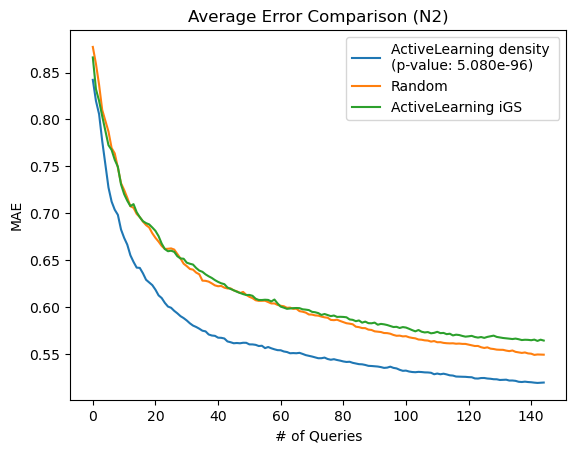

In [30]:
df1_1 = create_results('./ALresults/Real/N2/Al_n2_150_oracle_only_density')
df2_1 = create_results('./ALresults/Real/N2/Rd_n2_150_full')
df3_1 = create_results('./ALresults/Real/N2/Al_n2_150_oracle_only_iGS')

t_v, p_v = stat_test(df1_1,df2_1)
p_v = p_v.item()

plt.figure()
plt.plot(df1_1, label='ActiveLearning density')
plt.plot(df2_1, label='Random')
plt.plot(df3_1, label='ActiveLearning iGS')

plt.xlabel('# of Queries')
plt.ylabel('MAE')
plt.title('Average Error Comparison (N2)')

handles, labels = plt.gca().get_legend_handles_labels()

#labels.append(f'p-value: {p_v:.3e}')
labels[0] += f' \n(p-value: {p_v:.3e})'
plt.legend(handles, labels)
plt.show()

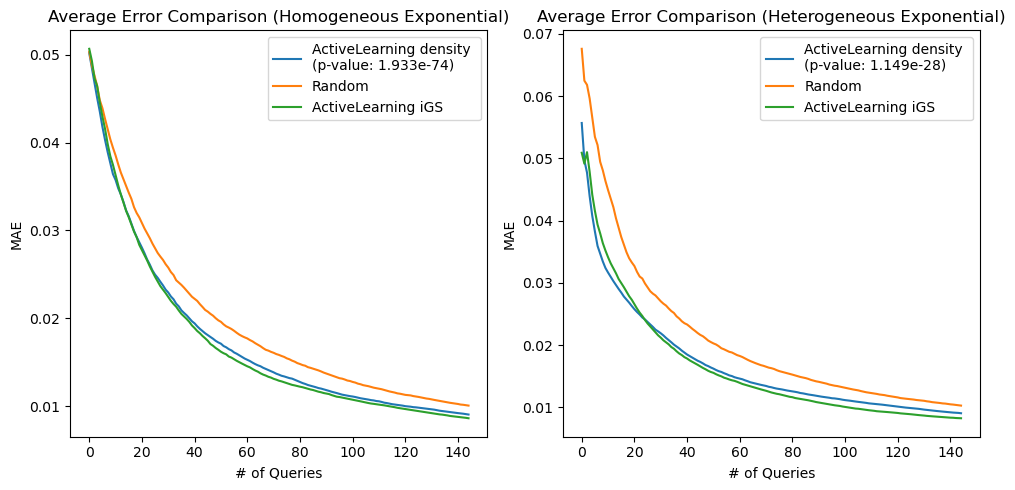

In [64]:
df1_1 = create_results('./ALresults/Synthetic/Exponential/Exponential/Al_exp_150_oracle_only_density')
df2_1 = create_results('./ALresults/Synthetic/Exponential/Exponential/Rd_exp_150_full')
df3_1 = create_results('./ALresults/Synthetic/Exponential/Exponential/Al_exp_150_oracle_only_iGS')

df1_2 = create_results('./ALresults/Synthetic/Exponential/Exponential_imb/Al_exp_150_oracle_only_density')
df2_2 = create_results('./ALresults/Synthetic/Exponential/Exponential_imb/Rd_exp_150_full')
df3_2 = create_results('./ALresults/Synthetic/Exponential/Exponential_imb/Al_exp_150_oracle_only_iGS')

# Perform statistical tests
t_v1, p_v1 = stat_test(df1_1, df2_1)
t_v2, p_v2 = stat_test(df1_2, df2_2)

# Convert p-values to scalar if needed
p_v1 = p_v1.item()
p_v2 = p_v2.item()

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
ax[0].plot(df1_1, label='ActiveLearning density')
ax[0].plot(df2_1, label='Random')
ax[0].plot(df3_1, label='ActiveLearning iGS')
ax[0].set_xlabel('# of Queries')
ax[0].set_ylabel('MAE')
ax[0].set_title('Average Error Comparison (Homogeneous Exponential)')
handles, labels = ax[0].get_legend_handles_labels()
labels[0] += f' \n(p-value: {p_v1:.3e})'
ax[0].legend(handles, labels)

# Second subplot
ax[1].plot(df1_2, label='ActiveLearning density')
ax[1].plot(df2_2, label='Random')
ax[1].plot(df3_2, label='ActiveLearning iGS')
ax[1].set_xlabel('# of Queries')
ax[1].set_ylabel('MAE')
ax[1].set_title('Average Error Comparison (Heterogeneous Exponential)')
handles, labels = ax[1].get_legend_handles_labels()
labels[0] += f' \n(p-value: {p_v2:.3e})'
ax[1].legend(handles, labels)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()